[![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# 具有消息摘要和外部数据库记忆的聊天机器人

## 回顾

我们已经介绍了怎样自定义图状态模式和 reducer。
 
我们还展示了一些裁剪和过滤图状态中的消息的技巧。

我们已经将这些概念用在了一个具有记忆的聊天机器人上，该机器人可以生成对话的运行摘要。

## 目标

但是，如果我们想让我们的聊天机器人拥有永久的持久化记忆呢？

现在，我们将介绍一些高级的检查器来支持外部的数据库。

这里，我们将展示怎样使用[Sqlite 作为一个检查器](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer)，但是其他检查器，如[Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) 也是可用的!

In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [15]:
import yaml

# 我没有openai的api key，所以使用qwen的openai兼容接口，需要设置qwen的api key和base url，我选择从配置文件.yml中读取
with open("../.yml", "r") as f:
    config = yaml.safe_load(f)

qwen_config = config["llm"]["qwen"]


## Sqlite

这是一个好的七点，这是 [SqliteSaver 检查器](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite 是一个 [轻量，快速且非常受欢迎的](https://x.com/karpathy/status/1819490455664685297) SQL 数据库。 
 
如果我们提供 `":memory:"` 它将创建一个内存中的 Sqlite 数据库。

In [47]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

但是，如果我们提供一个数据库路径，它将为我们创建一个数据库！

In [48]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [49]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)


让我们重定义我们的chatbot.

In [45]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="qwen-max", base_url=qwen_config["base_url"], api_key=qwen_config["api_key"], temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above, only output the summary, no other text:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above, only output the summary, no other text:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

现在，我们只要用我们的数据库检查点重新编译我们的图。

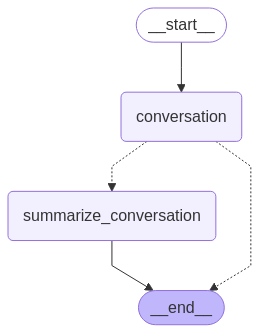

In [56]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

现在，我们可以多次执行这个图。

In [57]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! It's nice to see you again. You mentioned that you like the 49ers. Is there anything specific about the 49ers you'd like to talk about, or is there another topic you're interested in?
================================== Ai Message ==================================

Your name is Lance! Is there anything else you'd like to chat about, Lance?
================================== Ai Message ==================================

That's great, Lance! The 49ers have a rich history and a passionate fan base. Is there anything specific you'd like to discuss about the 49ers? Maybe their current roster, recent games, or any favorite players or moments?


让我们确认我们的状态已经被存在了本地。

In [58]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='b1ce4456-948a-467d-806e-41e2e6b20baf'), AIMessage(content="Hello Lance! It's nice to see you again. You mentioned that you like the 49ers. Is there anything specific about the 49ers you'd like to talk about, or is there another topic you're interested in?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 331, 'total_tokens': 380, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'qwen-max', 'system_fingerprint': None, 'id': 'chatcmpl-532a82a7-e45a-995c-ab63-b05bac82a697', 'finish_reason': 'stop', 'logprobs': None}, id='run-55b2de04-bcfd-44dc-9522-1748c2162722-0', usage_metadata={'input_tokens': 331, 'output_tokens': 49, 'total_tokens': 380, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}), HumanMessage(content="w

### 持久化状态

使用想SQLite这样的数据库意味着状态被持久化了！

例如，我们可以重启 notebook kernel 来确认我们仍然可以从磁盘上的 Sqlite 数据库中加载


In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", id='d5bb4b3f-b1e9-4f61-8c75-7a7210b30253'), AIMessage(content="Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 337, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-dde04d51-d305-4a9e-8ad5-6bdf5583196e-0', usage_metadata={'input_tokens': 337, 'output_tokens': 50, 'total_tokens': 387}), HumanMessage(content="what's my name?", id='d7530770-f130-4a05-a602-a96fd87859c6'), AIMessage(content='Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?', additional_kwargs={'

In [62]:
# 再试试mysql版的
from langgraph.checkpoint.mysql.aio import AIOMySQLSaver

config = {"configurable": {"thread_id": "2"}}
async with AIOMySQLSaver.from_conn_string("mysql+aiomysql://db_rw:EU23sa2wv:T6UYM@10.0.48.12:3306/test?charset=utf8mb4&collation=utf8mb4_0900_ai_ci&parseTime=true&loc=Local") as checkpointer:
    # call .setup() the first time you're using the checkpointer
    # await checkpointer.setup()
    # Compile
    graph = workflow.compile(checkpointer=checkpointer)

    # 用异步的方式
    # Start conversation
    input_message = HumanMessage(content="hi! I'm Lance")
    output = await graph.ainvoke({"messages": [input_message]}, config) 
    for m in output['messages'][-1:]:
        m.pretty_print()

    input_message = HumanMessage(content="what's my name?")
    output = await graph.ainvoke({"messages": [input_message]}, config) 
    for m in output['messages'][-1:]:
        m.pretty_print()

    input_message = HumanMessage(content="i like the 49ers!")
    output = await graph.ainvoke({"messages": [input_message]}, config) 
    for m in output['messages'][-1:]:
        m.pretty_print()

================================== Ai Message ==================================

Hello Lance! It's nice to see you again. You mentioned earlier that you like the 49ers. Do you have a favorite player on the team, or are you looking forward to any upcoming games?
================================== Ai Message ==================================

Your name is Lance! Is there anything specific you'd like to chat about, or do you have any other questions?
================================== Ai Message ==================================

That's great, Lance! The 49ers have a rich history and a passionate fan base. Do you have a favorite player on the team, or are you looking forward to any upcoming games?


In [75]:
# 试试mysql版的持久化
async with AIOMySQLSaver.from_conn_string("mysql+aiomysql://db_rw:EU23sa2wv:T6UYM@10.0.48.12:3306/test?charset=utf8mb4&collation=utf8mb4_0900_ai_ci&parseTime=true&loc=Local") as checkpointer:
        # Create a thread
    config = {"configurable": {"thread_id": "2"}}
    graph = workflow.compile(checkpointer=checkpointer)
    graph_state = await graph.aget_state(config)
    print(graph_state.values.keys())
    print(graph_state.values["summary"])
    for m in graph_state.values['messages']:
        m.pretty_print()

    
    

dict_keys(['messages', 'summary'])
Lance introduced himself and mentioned that he likes the San Francisco 49ers. He was asked if he had a favorite player or was looking forward to any upcoming games. Lance then reintroduced himself, and the conversation circled back to his interest in the 49ers, with the same question about a favorite player or upcoming games.
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! It's nice to see you again. You mentioned earlier that you like the 49ers. Do you have a favorite player on the team, or are you looking forward to any upcoming games?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Lance! Is there anything specific you'd like to chat about, or do you have any other 

## LangGraph Studio

要启动本地开发服务器，请在该module的 `/studio` 目录中的终端中运行以下命令：

```
langgraph dev
```

您应该看到以下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

O打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.